# Analyzing 19th Century Literature w.r.t. the Bechdel Test


Havan Agrawal  
DATA 516 - Human Centered Data Science  
University of Washington - Fall 2018

## Introduction

Gender diversity has always been an area of interest for human-centered studies, and one that has been well-explored. However, the idea of evaluating gender diversity, and representation of minorities and/or marginalized communities in fiction has gained traction only in the past few years (\[1\], \[2\], \[3\], \[4\]). With increasing focus on better representation, it is important to make sure that we are making progress on all fronts.

One rather well-known test for evaluating women representation in fiction is the [Bechdel test](https://en.wikipedia.org/wiki/Bechdel_test). It asks whether _at least two women who talk to each other about something other than a man._

The test is ambiguous in many regards, and indeed, the results are known to vary depending on how rigorously the test is applied. If we use the definition as "at least one such conversation", then the bar is too low, and allows a lot of works to pass the test even if they have poor women representation. On the other hand, if a long, meaningful conversation between two women just happens to mention a man in passing, it shouldn't invalidate the entire exchange.

Further, there have definitely been attempts to automate the test (\[5\], \[6\]). However, these agree that:
1. It is challenging to claim with high confidence whether or not a piece of fiction passes the test, often because of varying levels of rigor can alter the result
2. No methodology exists for performing this test at scale.

In this notebook, I attempt to analyze popular 19th century works of literature w.r.t. the Bechdel test. I hope to answer two primary questions:

**RQ1: Do popular works of literature pass the Bechdel test, and to what extent?**  
**RQ2: What gaps exist in current tools, techniques and methodologies that may hinder us from answering sociological questions such as this one, at scale?**

In the process, I wish to validate the following hypothesis:

**Even with the current state-of-the-art, It is inadvisable to try to scale sociological tests such as the Bechdel test using complete automation and/or machine learning. Instead, an iterative, interactive and qualitative analysis for each novel needs to be performed, due to the many nuances of a test such as this.**

## Why Does This Matter

> _It's in literature that true life can be found. It's under the mask of fiction that you can tell the truth._  
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Gao Xignjian

I have been an avid and voracious reader ever since the age of 12. I find books to be a fantastic source of knowledge, information and personal growth. Whether it is fictional, biographical or historical, a good novel captivates you, pulls you from the physical realm into itself. Further still, I believe that works of fiction often captures the true nature of society. They either reflect on the world, as it is, or what it might become. Either consciously or subconsciously, the worlds created by a writer capture their perspective. 

As children, we have grown up on novels such as Alice in Wonderland, Harry Potter and the ilk. If there indeed exist biases, be it w.r.t. representation of women or any other minorities, these biases will be picked up at an early age through no fault of the child's. Thus it is important to have the ability to evaluate works of fiction for the presence of bias.

## Reproducibility

While each independent notebook is completely reproducible, due to the qualitative nature of the analyses, it is not possible to replicate the research _as is_ for any arbitrary novel. Instead, I recommmend using the template notebook in the repository (ref), and modifying it to suit the novel at hand.

## Analyzing Pride and Prejudice

### Getting Started

First off, let's import all the libraries that we need:

In [1]:
import json
from collections import defaultdict, Counter

from unidecode import unidecode

We load a small utility module that has some basic text processing and convenience functions:

In [2]:
import bechdel_utils
from bechdel_utils import *
help(bechdel_utils)

Help on module bechdel_utils:

NAME
    bechdel_utils

FUNCTIONS
    about_man(s, gender_dict)
        Return a dictionary of gender to relative frequency of mention/reference
    
    compress(speakers, talks)
        Reduce consecutive dialogue by the same person into single records
    
    prettify(name)
        Properly capitalize a name
        
        >>> prettify("edgar ATHELING")
        "Edgar Atheling"
    
    resolve(speakers, coreferents, who)
        Resolve coreferents.

DATA
    FEMALE_INDICATORS = {'girl', 'her', 'hers', 'she', 'woman'}
    MALE_INDICATORS = {'boy', 'he', 'him', 'his', 'man'}

FILE
    /Users/havan/Dropbox/CP/Git/data-512-final-project/bechdel_utils.py




In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
# Shut off pretty printing to save on space and keep the notebook concise
%pprint

Pretty printing has been turned OFF


We need to determine conversations, speakers and their genders. While this step may vary sometimes (since it may be simpler to not use machine learning for certain novels such as Hamlet), typically it is best to use the StanfordNER package to generate a JSON file that has the required details:

```bash
java -Xmx10g -cp "stanford-corenlp-full-2018-10-05/*" edu.stanford.nlp.pipeline.StanfordCoreNLP -annotators tokenize,ssplit,pos,lemma,ner,depparse,coref,quote -file novels/pride-and-prejudice.txt -outputFormat json
```

This will generate a JSON file, whose structure schema can be found [here](). We use this JSON file as input:

In [5]:
book = json.load(open("annotated/pride-and-prejudice-whole.txt.json"))
book.keys()

dict_keys(['docId', 'sentences', 'corefs', 'quotes'])

A brief description of the fields:

| field     | meaning |
|-----------|------------------------|
| docId     | Name of the input file |
| sentences | An array of sentences broken into a lexical tree |
| corefs    | A dictionary caontaining coreferents, and the entity they refer to, along with the position in text |
| quotes    | A list of spoken sentences, along with the speaker's name |

## 1. Two Women...

First, we find all named entities in the novel:

In [6]:
people = set()
for sentence in book['sentences']:
    for mention in sentence['entitymentions']:
        if mention['ner'] == 'PERSON':
            name = prettify(mention['text'])
            people.add(name)

Let's look at a random sample of these:

In [7]:
import random
random.seed(1436)
{random.choice(list(people)) for _ in range(10)}

{'Charlotte', 'Netherfield', 'Jenkinson', 'Hatfield', 'Elizabeth', 'Bakewell', 'Carter', 'Poor Reynolds', 'Darcy', 'Georgiana'}

The `canonicalSpeaker` field contains a reference to the original speaker entity, which is useful when the `speaker` field contains a pronoun:

In [8]:
speakers = [prettify(s['speaker']) for s in book["quotes"]]
canonical_speakers = [prettify(s['canonicalSpeaker']) for s in book["quotes"]]
talks = [unidecode(s['text']) for s in book['quotes']]

A quick example of how the canonicalSpeaker field can help:

In [9]:
unknown_speaker = {'She', 'Her', 'He', 'Him', 'His', 'Unknown'}
[c for c in zip(speakers, canonical_speakers, talks) if c[0] in unknown_speaker and c[1] not in unknown_speaker][10]

('Unknown', 'Elizabeth Bennet', '"What does Mr. Darcy mean,"')

In [10]:
unknown_speaker = {'She', 'Her', 'He', 'Him', 'His', 'Unknown'}
for i in range(len(speakers)):
    if speakers[i] in unknown_speaker and canonical_speakers[i] not in unknown_speaker:
        speakers[i] = prettify(canonical_speakers[i])

In [11]:
set(speakers)

{'Unknown', 'Rosings', 'Him', 'Wickham', 'Pemberley', 'Miss De Bourgh', 'Collins', 'Bennet', 'Longbourn', 'Charlotte', 'His', 'Lady Catherine', 'Elizabeth Bennet', 'Maria', 'Jane', 'Miss Eliza', 'Fitzwilliam', 'Denny', 'Hill', 'Housekeeper', 'Butler', 'James', 'Lady Lucas', 'Meryton', 'Miss Bingley', 'Elizabeth: ``lizzy', 'Catherine', 'Bingley', 'Gardiner', 'Her', 'Mary', 'Lucas', 'Charles', 'She', 'Phillips', 'Reynolds', 'Companion', 'Caroline', 'Lizzy', 'Forster', 'He', 'Elizabeth', 'Lydia', 'Netherfield', 'Miller', 'Charlotte Lucas', 'Hurst', 'Miss Bennet', 'Kitty', 'Darcy', 'William'}

Since a single person can have many [coreferents](https://en.wikipedia.org/wiki/Coreference), and the algorithm is not great at identifying all of them, we try to fix a few:

In [12]:
resolve(speakers, {"Elizabeth: ``lizzy", "Elizabeth", "Lizzy", "Dear Lizzy"}, "Elizabeth Bennet")
resolve(speakers, {"Bingley", "Miss. Bingley"}, "Miss Bingley")
resolve(speakers, {"Charlotte"}, "Charlotte Lucas")
resolve(speakers, {"Catherine"}, "Lady Catherine")
resolve(speakers, {"Fitzwilliam", "Darcy"}, "Fitzwilliam Darcy")
resolve(speakers, {"Miss Darcy"}, "Georgiana Darcy")

In [13]:
set(speakers)

{'Unknown', 'Rosings', 'Him', 'Wickham', 'Pemberley', 'Miss De Bourgh', 'Collins', 'Bennet', 'Longbourn', 'His', 'Lady Catherine', 'Elizabeth Bennet', 'Maria', 'Jane', 'Miss Eliza', 'Denny', 'Hill', 'Housekeeper', 'Butler', 'James', 'Lady Lucas', 'Meryton', 'Miss Bingley', 'Gardiner', 'Her', 'Mary', 'Lucas', 'She', 'Phillips', 'Reynolds', 'Companion', 'Caroline', 'Netherfield', 'Forster', 'He', 'Miller', 'Lydia', 'Charlotte Lucas', 'Hurst', 'Fitzwilliam Darcy', 'Miss Bennet', 'Kitty', 'Charles', 'William'}

### Fixing Misattributions

In [14]:
def who_said_what(who):
    for i, s in enumerate(speakers):
        if s == who:
            talk = talks[i]
            if len(talk) > 100:
                talk = talk[:50] + "..." + talk[-50:]
            print(i, talk)
            print()

Rosings, Longbourn, Netherfield, Meryton and Pemberly are simply locations or estates, so they should ideally not have any speech attributed to them

In [15]:
who_said_what("Rosings")

831 "that I should not have been at all surprised by h...e whole party) so immediately after your arrival!"

983 "Be not alarmed, madam, on receiving this letter, ... will only add, God bless you. "FITZWILLIAM DARCY"



The first is said by Mr Collins, the other is a letter indeed from the Rosings estate, but is written by Mr Darcy (Fitzwilliam), and so we attribute it to him:

In [16]:
speakers[831] = "Collins"
speakers[983] = "Fitzwilliam Darcy"

In [17]:
who_said_what("Longbourn")

797 "I am now convinced, my dear aunt, that I have nev...t have something to live on as well as the plain."

1545 "If you were to give me forty such men, I never co...uck, I may meet with another Mr. Collins in time."

1733 "My real purpose was to see _you_, and to judge, i...ke the confession to him which I have since made."



In [18]:
speakers[797] = speakers[1545] = "Elizabeth Bennet"
speakers[1733] = "Fitzwilliam Darcy"

In [19]:
who_said_what("Netherfield")

392 "If you mean Darcy,"

393 "he may go to bed, if he chooses, before it begins...e white soup enough, I shall send round my cards."



In [20]:
speakers[392] = speakers[393] = "Charles"

In [21]:
who_said_what("Meryton")

141 "With great energy; but it is always a subject which makes a lady energetic."

142 "You are severe on us."



In [22]:
speakers[141] = "Fitzwilliam Darcy"
speakers[142] = "Elizabeth Bennet"

In [23]:
who_said_what("Pemberley")

1652 "I cannot give you credit for any philosophy of th...nsions to please a woman worthy of being pleased."



In [24]:
speakers[1652] = "Fitzwilliam Darcy"

### Gender Determination

Next, we extract the genders of all known entities from the novel

In [25]:
gender_dict = defaultdict(str)
for _, corefs in book['corefs'].items():
    for refs in corefs:
        name = prettify(refs['text'])
        gender = refs['gender']
        if name in set(speakers):
            gender_dict[name] = gender
            
gender_dict

defaultdict(<class 'str'>, {'She': 'FEMALE', 'Her': 'FEMALE', 'Kitty': 'FEMALE', 'Him': 'MALE', 'Mary': 'FEMALE', 'His': 'MALE', 'He': 'MALE', 'Lydia': 'FEMALE', 'Miss Bingley': 'FEMALE', 'Miss Bennet': 'FEMALE', 'Lady Catherine': 'FEMALE', 'Lady Lucas': 'FEMALE', 'Jane': 'FEMALE', 'Caroline': 'FEMALE', 'Wickham': 'UNKNOWN', 'Charles': 'MALE', 'Charlotte Lucas': 'MALE', 'Miss De Bourgh': 'MALE', 'Elizabeth Bennet': 'FEMALE', 'Denny': 'MALE', 'Miss Eliza': 'FEMALE', 'Maria': 'FEMALE', 'Forster': 'MALE', 'Lucas': 'MALE', 'Hill': 'MALE'})

We can see one person's gender is unknown, which we can correct:

In [26]:
gender_dict.update({
    "Wickham": "MALE",
})

It'll be interesting to visualize the gender ratios at this stage:

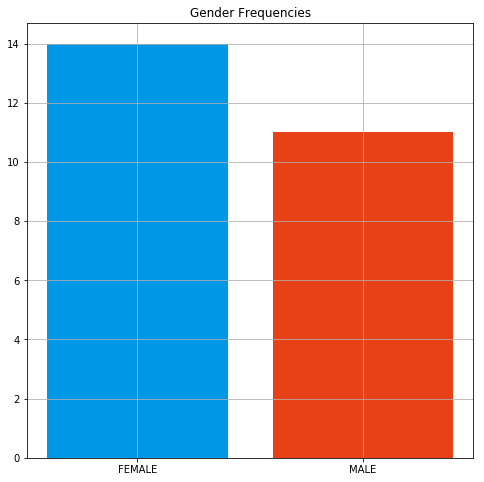

In [27]:
gender_counts = Counter(gender_dict.values())
plt.figure(figsize=(8, 8))
plt.bar(gender_counts.keys(), gender_counts.values(), color=['#0097e6', '#e84118'])
plt.title("Gender Frequencies")
plt.grid()

In [28]:
def female(s):
    return gender_dict[s] == "FEMALE"

def male(s):
    return gender_dict[s] == "MALE"

def unknown(s):
    return gender_dict[s] == "UNKNOWN"

def neutral(s):
    return gender_dict[s] == "NEUTRAL"

## 2. Talk to Each Other...

We will use a simple heuristic for determining if two people are talking to each other:
1. P1 talks
2. P2 Talks
3. P1 Talks

i.e. we try to find triplets (p1, p2, p1), and assume that p1 and p2 are cognizant of one another, and are talking to each other.

### Creating Triplets

This needs two passes:
1. We need to compress a speaker who is speaking continuously into a single instance
2. We then look for triplet occurrences, and store them as ordered pairsaa

In [29]:
compressed_speakers, compressed_talks = compress(speakers, talks)

In [30]:
compressed_speakers[:40]

['', 'His', 'Bennet', 'Kitty', 'Bennet', 'His', 'Unknown', 'Miss Bingley', 'Her', 'Him', 'His', 'William', 'Elizabeth Bennet', 'Unknown', 'His', 'Her', 'Bennet', 'Her', 'Him', 'Elizabeth Bennet', 'Her', 'Bennet', 'Her', 'Kitty', 'Elizabeth Bennet', 'Her', 'Him', 'Her', 'Him', 'Bennet', 'Unknown', 'Mary', 'His', 'Kitty', 'Bennet', 'Mary', 'Lydia', 'Bennet', 'Lady Lucas', 'Fitzwilliam Darcy']

In [31]:
for c in zip(compressed_speakers[2:5], compressed_talks[2:5]):
    print(":\t".join(c))

Bennet:	have you heard that Netherfield Park is let at last?
Kitty:	But it is, for Mrs. Long has just been here, and she told me all about it.
Bennet:	Do you not want to know who has taken it?


Now that we have the compressed dialog, we can create triplets. The way we will do this is:

1. Find a triplet that satisfies the conversation criteria
2. Order the speakers lexicographically into an ordered pair
3. Key into this pair and store all text that they speak to each other.

In [32]:
p1 = list(compressed_speakers)
p2 = list(compressed_speakers[1:])
p3 = list(compressed_speakers[2:])

t1 = list(compressed_talks)
t2 = list(compressed_talks[1:])
t3 = list(compressed_talks[2:])

triplet_speakers = list(zip(p1, p2, p3))
triplet_talks = list(zip(t1, t2, t3))

### Creating Conversations

In [33]:
conversations = defaultdict(set)

for spkrs, tlks in zip(triplet_speakers, triplet_talks):
    s1, s2, s3 = spkrs
    if s1 == s3:
        key = tuple(sorted([s1, s2]))
        conversations[key] |= set(tlks)

In [34]:
random.seed(1436)
random.choice(list(conversations[('Elizabeth Bennet', 'Fitzwilliam Darcy')]))

'And of your infliction, You have reduced him to his present state of poverty--comparative poverty. You have withheld the advantages which you must know to have been designed for him. You have deprived the best years of his life of that independence which was no less his due than his desert. You have done all this! and yet you can treat the mention of his misfortune with contempt and ridicule.'

## 3. About Something Other Than A Man?

We now need to determine if a conversation is about a man. We can use a few naive cues to determine this:
1. Presence of a name whose gender is known to be a man:
2. Presence of the words "he", "him", "his", and other similar words referring to a man:

In [35]:
elizabeth_darcy = sorted(list(conversations[('Elizabeth Bennet', 'Fitzwilliam Darcy')]))
for i, conversation in enumerate(elizabeth_darcy[:5]):
    print(conversation)
    print(about_man(conversation, gender_dict))
    print()

A man who has once been refused! How could I ever be foolish enough to expect a renewal of his love? Is there one among the sex, who would not protest against such a weakness as a second proposal to the same woman? There is no indignity so abhorrent to their feelings!
{'MALE': 0.03508771929824561, 'FEMALE': 0.017543859649122806}

And of your infliction, You have reduced him to his present state of poverty--comparative poverty. You have withheld the advantages which you must know to have been designed for him. You have deprived the best years of his life of that independence which was no less his due than his desert. You have done all this! and yet you can treat the mention of his misfortune with contempt and ridicule.
{'MALE': 0.08974358974358974, 'FEMALE': 0.0}

And so ended his affection, There has been many a one, I fancy, overcome in the same way. I wonder who first discovered the efficacy of poetry in driving away love!
{'MALE': 0.027777777777777776, 'FEMALE': 0.0}

And this,
{'MA

Now that we have a way of determining the extent to which a conversation _might_ be about a man, we can continue to analyze conversations between women, and look at some potential trends:

In [36]:
female_conversations = []
for p1, p2 in conversations:
    if female(p1) and female(p2):
        all_conversations = conversations[(p1, p2)]
        for convo in all_conversations:
            female_conversations.append(about_man(convo, gender_dict))

In [37]:
df = pd.DataFrame(female_conversations)
df.describe()

,FEMALE,MALE
count,155.000000,155.000000
mean,0.020859,0.022306
std,0.037020,0.034856
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.025641,0.034287
max,0.166667,0.148936


In [38]:
(df.FEMALE > df.MALE).mean(), (df.MALE > df.FEMALE).mean()

(0.28387096774193549, 0.30967741935483872)

We see that ~28% of conversations between women refer more to women than to men, and ~31% refer to men more than men. The rest are neutral, i.e. they refer to men and women equally.

In the final visualization, we can plot each conversation as a data point, with each axis representing the extent to which the conversation is about males or females:

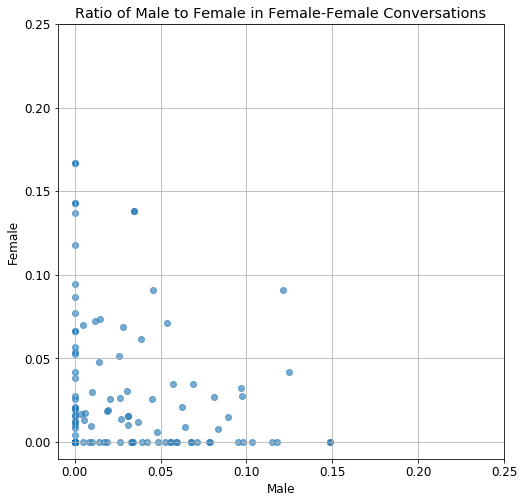

In [39]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=(8, 8))
plt.scatter(df.MALE, df.FEMALE, marker='o', alpha=0.6)
plt.grid()
a = plt.gca()
a.set_xlim((-0.01, 0.25))
a.set_ylim((-0.01, 0.25))
plt.xlabel("Male")
plt.ylabel("Female")
_ = plt.title("Ratio of Male to Female in Female-Female Conversations")

We can see that the line is closer to the male axis, with a slope of 1/4, meaning that on average, for every 4 conversations that are more male-centric, there is 1 female centric conversation (though this is a naive interpretation of the above data).

## Other Novels

We can perform a similar analysis for other novels, and the results are presented here directly from other notebooks:

### [Alice in Wonderland](http://www.gutenberg.org/files/11/11-0.txt)

> After a tumble down the rabbit hole, Alice finds herself far away from home in the absurd world of Wonderland. As mind-bending as it is delightful, Lewis Carroll’s 1865 novel is pure magic for young and old alike.

| Gender Ratios | Conversations |  
|--|--|  
|![Alice in Wonderland](images/aliceGenders.png) | ![Alice in Wonderland](images/alicePlot.png)| 

We can conclude that the novel **appears** to pass the Bechdel test (It should however be noted that this novel is a **nonsense** novel, with quite a few animals appearing as characters, who may or may not have a gender, so to speak.

### [Great Expectations](http://www.gutenberg.org/files/1400/1400-0.txt)

> In what may be Dickens's best novel, humble, orphaned Pip is apprenticed to the dirty work of the forge but dares to dream of becoming a gentleman — and one day, under sudden and enigmatic circumstances, he finds himself in possession of "great expectations." In this gripping tale of crime and guilt, revenge and reward, the compelling characters include Magwitch, the fearful and fearsome convict; Estella, whose beauty is excelled only by her haughtiness; and the embittered Miss Havisham, an eccentric jilted bride.

| Gender Ratios | Conversations |  
|--|--|  
|![Great Expectations](images/greatExpectationsGenders.png) | ![Great Expectations](images/greatExpectationsConversations.png)|

### [Hamlet](http://www.gutenberg.org/files/1524/1524-0.txt)

> Among Shakespeare's plays, "Hamlet" is considered by many his masterpiece. Among actors, the role of Hamlet, Prince of Denmark, is considered the jewel in the crown of a triumphant theatrical career. Now Kenneth Branagh plays the leading role and co-directs a brillant ensemble performance. Three generations of legendary leading actors, many of whom first assembled for the Oscar-winning film "Henry V", gather here to perform the rarely heard complete version of the play. This clear, subtly nuanced, stunning dramatization, presented by The Renaissance Theatre Company in association with "Bbc" Broadcasting, features such luminaries as Sir John Gielgud, Derek Jacobi, Emma Thompson and Christopher Ravenscroft. It combines a full cast with stirring music and sound effects to bring this magnificent Shakespearen classic vividly to life. Revealing new riches with each listening, this production of "Hamlet" is an invaluable aid for students, teachers and all true lovers of Shakespeare - a recording to be treasured for decades to come.

| Gender Ratios | Conversations |  
|--|--|  
|![Hamlet](images/hamletGenders.png) | ![Hamlet](images/hamletConversations.png)|

Hamlet performs exceptionally poorly, with poor women representation overall, as well as complete lack of conversation between any two women.

## Limitations

1. We only use the genders of speakers, and ignore the gender of names which occur in `people` but not in `gender_dict`. To make the notebook more precise, we could either try to infer the gender of various entities from the context of the novel, or fill them in manually.
2. We consider **only binary genders**, and treat others as neutral, which do not contribute to the custom Bechdel score.
3. The StanfordNER algorithm often **performs poorly at attributing speech** to the correct speaker. In cases where the gender of the speaker is different, this can affect the results significantly. The best way to evaluate the performance of the algorithm in a quantitative context would be to annotate a novel manually, and measure how much the results differ from the algorithm's.

## Conclusion

We observe that most novels appear to have more than twice as many males as females, with Jane Austen's Pride and Prejudice being a notable exception. Further, they appear to be slightly biased towards male-centric conversations; indeed, Hamlet turns out to have only a handful of conversations between females, which speaks volumes.

While this research is neither novel nor groundbreaking, it highlights that even state-of-the-art NLP fall short of providing a competent tool box for performing large scale sociological studies such as this.

## References

1. [Women better represented in Victorian novels than modern](https://www.theguardian.com/books/2018/feb/19/women-better-represented-in-victorian-novels-than-modern-finds-study)
2. [Why Diverse Fiction Matters](https://www.tckpublishing.com/why-diverse-fiction-matters/)
3. [Why We Need Diverse YA Books That Represent Marginalized Characters In All Of Their Complex, Quirky Glory](https://www.bustle.com/p/why-we-need-diverse-ya-books-that-represent-marginalized-characters-in-all-of-their-complex-quirky-glory-8003404)  
4. [This is Why We Need Diversity in Fiction](https://katetilton.com/diversity-fiction/)
5. [Automating The Bechdel-Wallace Test](http://nht.ecs.soton.ac.uk/2011/papers/12-flawrence.pdf)
6. [Key Female Characters in Film Have More to Talk About Besides Men: Automating the Bechdel Test](http://aclweb.org/anthology/N/N15/N15-1084.pdf)